# <a id='toc1_'></a>[Data Integration & Transformation](#toc0_)

**Author:** Salman Tahir  
**Environment:** Conda 23.7.2, Python 3.10.12

---


**Table of contents**<a id='toc0_'></a>

-   [Introduction](#toc2_)
-   [Pre-defined Information](#toc3_)
-   [Importing Libraries](#toc4_)
-   [Data Loading](#toc5_)
    -   [Loading Sample data](#toc5_1_)
    -   [Loading XML data](#toc5_2_)
    -   [Loading JSON data](#toc5_3_)
    -   [Loading Shapefile data](#toc5_4_)
    -   [Loading GTFS data](#toc5_5_)
    -   [Loading PDF data](#toc5_6_)
-   [Data Integration](#toc6_)
    -   [Integrating XML & JSON data](#toc6_1_)
    -   [Integrating Data from Sources](#toc6_2_)
    -   [Scraping Website for Housing Data](#toc6_3_)
    -   [Addressing Duplication Issues](#toc6_4_)
-   [Data Export](#toc7_)
-   [Data Transformation](#toc8_)
    -   [Preparing Data for Analysis](#toc8_1_)
    -   [Standardization](#toc8_2_)
    -   [Normalization](#toc8_3_)
    -   [Log Transformation](#toc8_4_)
    -   [Power Transformation](#toc8_5_)
    -   [Box-Cox Transformation](#toc8_6_)
    -   [Effect of Data Transformation on Linear Regression Models](#toc8_7_)
-   [Summary](#toc9_)
-   [References](#toc10_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


# <a id='toc2_'></a>[Introduction](#toc0_)

Data integration is a crucial process that involves merging data from multiple sources to create a unified and comprehensive view. In this project, we will focus on integrating diverse datasets pertaining to housing information in Victoria, Australia. These datasets originate from various sources and are presented in different formats.

Our primary objective is to merge these datasets into a cohesive mediated schema or dataset. Throughout the integration process, we will prioritise ensuring the validity and integrity of the data by cross-referencing it with the provided sample output. Additionally, we will address data cleaning requirements where necessary. Lastly, we explore the impact of employing various data transformation methods and techniques on the final dataset, highlighting their effects and benefits.


# <a id='toc3_'></a>[Pre-defined Information](#toc0_)

We are provided with the following data sources:

-   CSV file (Sample Output)
    -   `sample_output.csv`
-   XML file
    -   `properties.xml`
-   JSON file
    -   `properties.json`
-   Vic_suburb_boundary (directory), which contains the following files:
    -   `VIC_LOCALITY_POLYGON_shp.dbf`
    -   `VIC_LOCALITY_POLYGON_shp.prj`
    -   `VIC_LOCALITY_POLYGON_shp.shp`
    -   `VIC_LOCALITY_POLYGON_shp.shx`
-   Vic_GTFS_data (directory) -> metropolitan (subdirectory), which contains the following files:
    -   `agency.txt`
    -   `calendar_dates.txt`
    -   `calendar.txt`
    -   `routes.txt`
    -   `shapes.txt`
    -   `stop_times.txt`
    -   `stops.txt`
    -   `trips.txt`
-   PDF file containing information about the LGA to suburb mapping in Victoria, Australia.
    -   `Lga_to_suburb.pdf`
-   Webpage containing housing information that we need to scrape.
    -   `http://house.speakingsame.com/`

We are required to integrate data from these sources into a single mediated dataset that contains the same attributes as in the sample output file.

Furthermore, we have the following notes to consider from the project brief:

> If you decide not to calculate any of the required columns, then you must still have that column in your final DataFrame with all the values as the Default value: "`NA`" (string).

> Direct journey means that you can reach Melbourne Central Station without changing your train at any point in the journey. So, when you board the train at the closest station, you can directly go to the Melbourne Central Station without moving to another vehicle.

> The only external source of information is the webpage we need to scrape. All other information is provided in the input files.

> For Haversine distance, use 6378 km as the radius of the earth.


# <a id='toc4_'></a>[Importing Libraries](#toc0_)

In this section, we import several libraries that are essential for our data integration and analysis tasks.

-   `folium`: visualising geospatial data.
-   `geopandas`: working with geospatial data, allowing us to handle geographic data and perform spatial operations.
-   `matplotlib.pyplot`: plotting library to create graphs and charts.
-   `numpy`: numerical computing that provides efficient mathematical operations and array manipulations.
-   `os`: provides functions for interacting with the operating system
-   `pandas`: provides high-performance, easy-to-use data structures and data analysis tools.
-   `re`: regular expression operations.
-   `requests`: making HTTP requests.
-   `time`: time-related functions.
-   `warnings`: used for handling warnings.
-   `xml.etree.ElementTree`: parsing and manipulating XML files.
-   `BeautifulSoup`: parsing HTML and XML documents, extracting data from web pages.
-   `math`: provides mathematical functions and constants, such as for calculating the Haversine distance.
-   `pdfminer.high_level`: extracting text from PDF documents.
-   `shapely.geometry.Point`: defines geometric objects and operations related to points in space.
-   `sklearn`: several libraries were imported for machine learning algorithms and tools for data mining.

Additionally, we set the plotting style `plt.style.use('seaborn-v0_8')` to enhance the visual appearance of our plots.

We also adjust the display options of Pandas using `pd.set_option` to show all rows and columns in our DataFrames.


In [136]:
# Importing libraries
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import time
import warnings
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
from math import radians, cos, sin, asin, sqrt
from pdfminer.high_level import extract_text
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('muted')

# Pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# <a id='toc5_'></a>[Data Loading](#toc0_)

We import data from various sources into Pandas `DataFrames` that can be used for further processing or analysis.

Each dataset format requires a specific approach for loading the data.

-   <span style="color:green">CSV</span> _(Sample Output)_
    -   The pandas `read_csv` function is used to load data from CSV files into a DataFrame.
-   <span style="color:green">XML</span>
    -   The `xml.etree.ElementTree` library is used to parse the XML file.
    -   The XML data is then cleaned and loaded into a DataFrame using pandas' `read_xml` function.
-   <span style="color:green">JSON</span>
    -   The pandas `read_json` function is used to load data from JSON files into a DataFrame.
-   <span style="color:green">Shapefile</span>
    -   The geopandas `read_file` function is used to load data from Shapefiles into a GeoDataFrame.
-   <span style="color:green">GTFS</span>
    -   The pandas `read_csv` function is used to load data from GTFS files into multiple DataFrames.
-   <span style="color:green">PDF</span>
    -   The pdfminer library is used to extract text from the PDF file.
    -   The extracted text is then processed and loaded into a DataFrame.


## <a id='toc5_1_'></a>[Loading Sample data](#toc0_)


In [2]:
# Set path to sample file
FILE_PATH = '../data/sample/sample_output.csv'

# Read CSV file
df_sample = pd.read_csv(FILE_PATH)


In [3]:
print(df_sample.shape)
df_sample.head()


(15, 17)


,property_id,lat,lng,addr_street,suburb,number_of_houses,number_of_units,municipality,population,aus_born_perc,median_income,median_house_price,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
0,6076,-37.783143,144.841450,115 Cornwall Road,SUNSHINE,4031.0,1779.0,Brimbank,30677.0,52%,$929,"$888,500",KNOX,20021,0.963904,20.0,1
1,40076,-37.695698,145.063461,22 Chaucer Crescent,BUNDOORA,8943.0,3243.0,Whittlesea,24119.0,69%,"$1,172","$887,300",WODONGA,19984,2.468252,42.0,1
2,20299,-37.761231,144.964393,1/182 Albion St,BRUNSWICK,8835.0,8041.0,Moreland,20155.0,62%,"$1,433","$1,276,200",MARIBYRNONG,19967,0.326405,18.0,1
3,59305,-37.824275,145.197623,10 Simpson Street,MITCHAM,5802.0,3089.0,Whitehorse,14482.0,76%,"$1,424","$1,118,800",PORT PHILLIP,19900,0.856256,31.0,1
4,77582,-37.921211,145.164257,17 Wanda Street,MULGRAVE,7213.0,1477.0,Monash,22093.0,60%,"$1,348","$1,022,400",MACEDON RANGES,19914,2.946776,33.0,1


## <a id='toc5_2_'></a>[Loading XML data](#toc0_)


In [4]:
# Set path to XML file
FILE_PATH = '../data/input/properties.xml'

# Read XML file
with open(FILE_PATH, 'r') as file:
    try:
        tree = ET.parse(file)
    except Exception as e:
        print(e)


junk after document element: line 7, column 0


We have come across an error associated with the XML file as it is not valid.

After examining the structure of the file, we have identified the following:

-   The file is missing a root element
-   The file is missing an XML declaration
-   The ampersand character `'&'` is not escaped

We fix these issues and read the XML file to a DataFrame.


In [5]:
# Read XML file
with open(FILE_PATH, 'r') as file:
    xml_data = file.read()

# Replace ampersand with entity reference
xml_data = xml_data.replace('&', '&amp;')

# Add root element and XML declaration
xml_data = f'<root>\n{xml_data}\n</root>'
xml_data = '<?xml version="1.0" encoding="UTF-8"?>\n' + xml_data

# Read XML file to DataFrame
df_xml = pd.read_xml(xml_data, xpath='//property')


C:\Users\Salman\AppData\Local\Temp\ipykernel_14804\4000638252.py:13: FutureWarning: Passing literal xml to 'read_xml' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_xml = pd.read_xml(xml_data, xpath='//property')


In [6]:
print(df_xml.shape)
df_xml.head()


(1148, 4)


,property_id,lat,lng,addr_street
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant
1,75687,-37.907673,145.078034,13 Austin Street
2,58378,-37.829966,145.150185,9 Kalka Street
3,94290,-37.958445,145.076596,14 Pebble Beach Place
4,77108,-37.947456,145.114517,14 Rowson Grove


## <a id='toc5_3_'></a>[Loading JSON data](#toc0_)


In [7]:
# Set path to JSON file
FILE_PATH = '../data/input/properties.json'

# Read JSON file to DataFrame
df_json = pd.read_json(FILE_PATH)


In [8]:
print(df_json.shape)
df_json.head()


(1152, 4)


,property_id,lat,lng,addr_street
0,9567,-37.853324,144.717306,5 Keats Court
1,85576,-37.881875,145.000057,37 Gordon Street
2,57242,-37.827333,145.076323,30 Maling Road
3,88038,-37.941966,145.054341,1/51 Bulli Street
4,49139,-37.803613,145.082512,19 Kaleno View


## <a id='toc5_4_'></a>[Loading Shapefile data](#toc0_)


In [9]:
# Set path to  Shapefile
FILE_PATH = '../data/input/Vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp'

# Read shapefile to GeoDataFrame
gdf_shapefile = gpd.read_file(FILE_PATH)


In [10]:
print(gdf_shapefile.crs)
print(gdf_shapefile.shape)
gdf_shapefile.head()


EPSG:4283
(2973, 13)


,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,NaT,VIC2615,2012-04-27,NaT,UNDERBOOL,None,None,G,NaT,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,NaT,VIC1986,2012-04-27,NaT,NURRAN,None,None,G,NaT,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,NaT,VIC2862,2012-04-27,NaT,WOORNDOO,None,None,G,NaT,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,NaT,VIC734,2017-08-09,NaT,DEPTFORD,None,None,G,NaT,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,NaT,VIC2900,2012-04-27,NaT,YANAC,None,None,G,NaT,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


We can also plot the data on a map to display the boundaries of the suburbs, ensuring that the data is loaded correctly and validates our expectations regarding data belonging to Victoria, Australia.


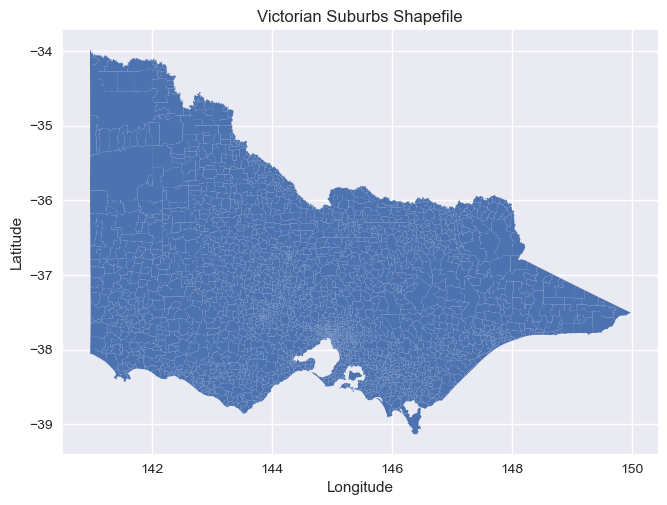

In [137]:
# Plot shapefile
gdf_shapefile.plot()

# Customise plot
plt.title('Victorian Suburbs Shapefile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## <a id='toc5_5_'></a>[Loading GTFS data](#toc0_)

For each file in the GTFS directory, we set the `FILE_PATH` variable to the name and location of the file and read it into a DataFrame.


In [12]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/agency.txt'

# Read GTFS file to DataFrame
df_agency = pd.read_csv(FILE_PATH)

print(df_agency.shape)
df_agency.head()


(1, 5)


,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,1,PTV,http://www.ptv.vic.gov.au,Australia/Melbourne,EN


In [13]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/calendar_dates.txt'

# Read GTFS file to DataFrame
df_calendar_dates = pd.read_csv(FILE_PATH)

print(df_calendar_dates.shape)
df_calendar_dates.head()


(2, 3)


,service_id,date,exception_type
0,T0,20151103,2
1,T0+a5,20151103,2


In [14]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/calendar.txt'

# Read GTFS file to DataFrame
df_calendar = pd.read_csv(FILE_PATH)

print(df_calendar.shape)
df_calendar.head()


(19, 10)


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018


In [15]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/routes.txt'

# Read GTFS file to DataFrame
df_routes = pd.read_csv(FILE_PATH)

print(df_routes.shape)
df_routes.head()


(81, 5)


,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
3,2-ALM-E-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
4,2-ALM-F-mjp-1,1,Alamein,Alamein - City (Flinders Street),2


In [16]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/shapes.txt'

# Read GTFS file to DataFrame
df_shapes = pd.read_csv(FILE_PATH)

print(df_shapes.shape)
df_shapes.head()


(339711, 5)


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,2-ain-mjp-1.1.H,-37.818631,144.951994,1,0.000000
1,2-ain-mjp-1.1.H,-37.817425,144.951050,2,157.543645
2,2-ain-mjp-1.1.H,-37.817241,144.950828,3,185.827916
3,2-ain-mjp-1.1.H,-37.816327,144.950047,4,308.469671
4,2-ain-mjp-1.1.H,-37.816127,144.949950,5,332.239399


In [17]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/stop_times.txt'

# Read GTFS file to DataFrame
df_stop_times = pd.read_csv(FILE_PATH)

print(df_stop_times.shape)
df_stop_times.head()


(390305, 9)


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


In [18]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/stops.txt'

# Read GTFS file to DataFrame
df_stops = pd.read_csv(FILE_PATH)

print(df_stops.shape)
df_stops.head()


(218, 5)


,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


In [19]:
# Set path to GTFS file
FILE_PATH = '../data/input/Vic_GTFS_data/metropolitan/trips.txt'

# Read GTFS file to DataFrame
df_trips = pd.read_csv(FILE_PATH)

print(df_trips.shape)
df_trips.head()


(23809, 6)


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


## <a id='toc5_6_'></a>[Loading PDF data](#toc0_)

Now, we'll use regular expressions to find all matches in the extracted PDF text that follow the pattern:

-   One or more uppercase letters, spaces, or hyphens
-   Followed by a colon and spaces
-   Followed by a sequence of word characters, spaces, commas, or single quotes enclosed in square brackets

For example in the text `"SUBURB NAME : ['Suburb1', 'Suburb2', 'Suburb3']"`

-   First capturing group
    -   `SUBURB NAME`
-   Second capturing group
    -   `'Suburb1', 'Suburb2', 'Suburb3'`.

After extracting the matches, we split the second capturing group by the comma character and remove the square brackets and single quotes from each element in the resulting list, while also removing any leading or trailing whitespace. The resulting list is then used to create a lookup DataFrame that maps each suburb to its corresponding LGA.


In [20]:
# Set path to PDF file
FILE_PATH = "../data/input/Lga_to_suburb.pdf"

# Extract text from PDF
pdf_text = extract_text(FILE_PATH)

# Extract suburb data from text using regular expressions
suburb_data = re.findall(r"([A-Z\s-]+)\s+:\s+\[([\w\s,']+)\]", pdf_text)

# Clean suburb names and create list of tuples
pdf_data = []
for lga, suburbs in suburb_data:
    cleaned_suburbs = []
    for suburb in suburbs.split(','):
        cleaned_suburb = suburb.replace("'", '').strip()
        cleaned_suburbs.append(cleaned_suburb)
    pdf_data.append((lga.strip(), cleaned_suburbs))

# Create a lookup format DataFrame from list of tuples
df_pdf = pd.DataFrame([(suburb, lga) for lga, suburbs in pdf_data for suburb in suburbs],
                      columns=['suburb', 'lga'])


In [21]:
print(df_pdf.shape)
df_pdf.head()


(335, 2)


,suburb,lga
0,Abbotsford,BANYULE
1,Airport West,BANYULE
2,Albert Park,BANYULE
3,Alphington,BANYULE
4,Altona,BRIMBANK


# <a id='toc6_'></a>[Data Integration](#toc0_)


## <a id='toc6_1_'></a>[Integrating XML & JSON data](#toc0_)

We start by integrating the XML and JSON data into a single DataFrame.

First, we identify any missing values in both DataFrames.


In [22]:
# Count of missing values in df_xml
print('Missing values in df_xml:')
print(df_xml.isnull().sum())
print()

# Count of missing values in df_json
print('Missing values in df_json:')
print(df_json.isnull().sum())


Missing values in df_xml:
property_id    0
lat            0
lng            0
addr_street    0
dtype: int64

Missing values in df_json:
property_id    0
lat            0
lng            0
addr_street    0
dtype: int64


We validate that both DataFrames have the same column names and data types ensuring that we can concatenate them into a single DataFrame.


In [23]:
# Check if column names are the same
print('Column names are the same:', df_xml.columns.equals(df_json.columns))

# Check if data types are the same
print('Data types are the same:', df_xml.dtypes.equals(df_json.dtypes))


Column names are the same: True
Data types are the same: True


Now, we look for any duplicate values in `df_xml`.


In [24]:
# Show duplicated rows grouped by property_id
df_xml[df_xml.duplicated(keep=False)].sort_values(by='property_id')


,property_id,lat,lng,addr_street
245,9548,-37.856301,144.716258,44 Tennyson Drive
866,9548,-37.856301,144.716258,44 Tennyson Drive
850,52603,-37.824093,145.001877,2 Bell Street
124,52603,-37.824093,145.001877,2 Bell Street
646,59516,-37.814928,145.187713,18 Victoria Avenue
571,59516,-37.814928,145.187713,18 Victoria Avenue
914,77659,-37.935430,145.197375,2 Scotsburn Close
168,77659,-37.935430,145.197375,2 Scotsburn Close
1083,77994,-37.925630,145.177199,38 Sunrise Drive
721,77994,-37.925630,145.177199,38 Sunrise Drive


After examining the duplicate values, we find that they are true duplicates as all columns have the same values. Therefore, we can safely remove them from the DataFrame.


In [25]:
# Remove duplicated rows
df_xml = df_xml.drop_duplicates()


Now, we look for any duplicate values in `df_json`.


In [26]:
# Show duplicated rows grouped by property_id
df_json[df_json.duplicated(keep=False)].sort_values(by='property_id')


,property_id,lat,lng,addr_street
726,17652,-37.703624,144.931424,72 Melbourne Avenue
636,17652,-37.703624,144.931424,72 Melbourne Avenue
120,34088,-37.721384,144.999318,19 Coleman Crescent
902,34088,-37.721384,144.999318,19 Coleman Crescent
51,65800,-37.788083,145.315231,15 Reay Road
664,65800,-37.788083,145.315231,15 Reay Road
284,82664,-37.900862,145.279953,22 Monbulk Crescent
139,82664,-37.900862,145.279953,22 Monbulk Crescent


After examining the duplicate values, we find that they are true duplicates as all columns have the same values. Therefore, we can safely remove them from the DataFrame.


In [27]:
# Remove duplicated rows
df_json = df_json.drop_duplicates()


Now, we concatenate both DataFrames into a single integrated DataFrame.


In [28]:
# Concatenate both DataFrames
df_final = pd.concat([df_xml, df_json])

print(df_final.shape)
df_final.head()


(2290, 4)


,property_id,lat,lng,addr_street
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant
1,75687,-37.907673,145.078034,13 Austin Street
2,58378,-37.829966,145.150185,9 Kalka Street
3,94290,-37.958445,145.076596,14 Pebble Beach Place
4,77108,-37.947456,145.114517,14 Rowson Grove


After concatenating the two DataFrames, we identify and remove any duplicate rows.


In [29]:
# Show duplicated rows grouped by property_id
df_final[df_final.duplicated(keep=False)].sort_values(by='property_id')


,property_id,lat,lng,addr_street
489,4361,-37.841832,144.866486,31 Carmen Street
802,4361,-37.841832,144.866486,31 Carmen Street
227,8849,-37.883029,144.754090,13 Seaside Close
102,8849,-37.883029,144.754090,13 Seaside Close
1143,9567,-37.853324,144.717306,5 Keats Court
0,9567,-37.853324,144.717306,5 Keats Court
918,14649,-37.753787,144.897179,6 Cooper Street
349,14649,-37.753787,144.897179,6 Cooper Street
603,46539,-37.719499,145.152573,127 Bridge Street
238,46539,-37.719499,145.152573,127 Bridge Street


As we can see above, the duplicate rows from both DataFrames are exactly the same. Therefore, we can safely remove them from the DataFrame.


In [30]:
# Remove duplicated rows
df_final = df_final.drop_duplicates(subset='property_id')

df_final.shape


(2278, 4)

Now, we can also check for duplicates based on the `addr_street` column, although we will require more information to determine whether these are actual duplicates or not, such as validating the `suburb` names for these properties, once we have integrated the `suburb` data into the DataFrame.


In [31]:
# Show duplicated rows grouped by addr_street
df_final[df_final.duplicated(subset='addr_street', keep=False)].sort_values(
    by='addr_street')


,property_id,lat,lng,addr_street
528,38189,-37.783310,145.031064,28 View Street
184,76734,-37.921931,145.110647,28 View Street
66,10440,-37.784744,144.924728,34 Illawarra Road
914,10439,-37.784681,144.924758,34 Illawarra Road
258,33291,-37.734672,145.006872,9 Walter Street
870,7115,-37.792627,144.843352,9 Walter Street


In [32]:
# Store property_id of duplicated rows into a list for later use
addr_duplicates = df_final[df_final.duplicated(
    subset='addr_street', keep=False)]['property_id'].tolist()
addr_duplicates


[38189, 10440, 76734, 33291, 7115, 10439]

Now, we have a single DataFrame that contains information from both the XML and JSON files.


In [33]:
# Reset index
df_final = df_final.reset_index(drop=True)

print(df_final.shape)

display(df_final.head())

display(df_final.tail())


(2278, 4)


,property_id,lat,lng,addr_street
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant
1,75687,-37.907673,145.078034,13 Austin Street
2,58378,-37.829966,145.150185,9 Kalka Street
3,94290,-37.958445,145.076596,14 Pebble Beach Place
4,77108,-37.947456,145.114517,14 Rowson Grove


,property_id,lat,lng,addr_street
2273,72525,-37.841518,145.253009,61 Suffern Avenue
2274,77626,-37.921236,145.167260,2 Danube Place
2275,40618,-37.683977,145.059852,41 Carbeen Drive
2276,92747,-37.986066,145.091385,15 Margaret Street
2277,80532,-37.988044,145.181827,8 York Court


## <a id='toc6_2_'></a>[Integrating Data from Sources](#toc0_)


### Integrating `suburb`

To integrate the `Suburb` column, we will refer to the `VIC_LOCALITY_POLYGON_shp` GeoDataFrame that we loaded earlier as `gdf_shapefile`.

Instead of manually iterating over the shapes in the shapefile to check if each property's coordinates are within each shape, we can use the `geopandas.sjoin` function to perform a spatial join between the two GeoDataFrames. This function will return a GeoDataFrame that contains the properties from the first GeoDataFrame (`gdf_final`) that intersect with the shapes from the second GeoDataFrame (`gdf_shapefile`). This approach is more efficient than manually iterating over the shapes in the shapefile.

Hence, we first ensure that our `df_final` columns `lat` and `lng` are of type `float`.


In [34]:
df_final.dtypes


property_id      int64
lat            float64
lng            float64
addr_street     object
dtype: object

We then convert the `df_final` DataFrame to a GeoDataFrame and create a `geometry` column as a Point object that contains the coordinates of each property using the `lat` and `lng` column values.


In [35]:
# Create a geometry column from lng and lat
geometry = [Point(xy) for xy in zip(df_final['lng'], df_final['lat'])]

# Create a GeoDataFrame from df_final
gdf_final = gpd.GeoDataFrame(df_final, geometry=geometry)

# Validate our created point object
print(geometry[0:1])
print()
print(df_final[['lng', 'lat']].head(1).round(3))


[<POINT (145.122 -37.783)>]

       lng     lat
0  145.122 -37.783


We spatially join both GeoDataFrames using a left join and create a new column `suburb` in `df_final` that contains the suburb values from the `VIC_LOCA_2` column in `gdf_merged`. Note that we also handle the case where a property is not located in any suburb by setting the `suburb` value to `NA`.


In [36]:
try:
    # Ensure both GeoDataFrames use same CRS
    gdf_final.set_crs(gdf_shapefile.crs, inplace=True)

    # Spatially join both GeoDataFrames
    gdf_merged = gpd.sjoin(gdf_final, gdf_shapefile,
                           how='left', predicate='within')

    # Add 'suburb' column to df_final
    df_final['suburb'] = gdf_merged['VIC_LOCA_2']

    # Replace any NaN values in 'suburb' column with 'NA'
    df_final['suburb'].fillna('NA', inplace=True)

except Exception as e:
    print(e)
    df_final['suburb'] = 'NA'


C:\Users\Salman\AppData\Local\Temp\ipykernel_14804\158992630.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['suburb'].fillna('NA', inplace=True)


In [37]:
# Reset index
df_final = df_final.reset_index(drop=True)

# Check if 'NA' in 'suburb' column
print('NA' in df_final['suburb'].unique())


False


In [38]:
print(df_final.shape)
df_final.head()


(2278, 5)


,property_id,lat,lng,addr_street,suburb
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant,DONCASTER
1,75687,-37.907673,145.078034,13 Austin Street,HUGHESDALE
2,58378,-37.829966,145.150185,9 Kalka Street,BLACKBURN
3,94290,-37.958445,145.076596,14 Pebble Beach Place,HEATHERTON
4,77108,-37.947456,145.114517,14 Rowson Grove,CLARINDA


### Integrating `lga`

We refer to the `df_pdf` lookup DataFrame that we created earlier by extracting LGA and suburb information form the provided PDF file.


In [39]:
# Convert suburb column to uppercase
df_pdf['suburb'] = df_pdf['suburb'].str.upper()

df_pdf.head()


,suburb,lga
0,ABBOTSFORD,BANYULE
1,AIRPORT WEST,BANYULE
2,ALBERT PARK,BANYULE
3,ALPHINGTON,BANYULE
4,ALTONA,BRIMBANK


In [40]:
try:
    # Merge df_final with df_pdf based on 'suburb'
    df_final = pd.merge(df_final, df_pdf, on='suburb', how='left')

    # Replace any NaN values in 'lga' column with 'NA'
    df_final['lga'].fillna('NA', inplace=True)

except Exception as e:
    print(e)
    df_final['lga'] = 'NA'


C:\Users\Salman\AppData\Local\Temp\ipykernel_14804\2837105928.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['lga'].fillna('NA', inplace=True)


In [41]:
# Check if 'NA' in 'lga' column
print('NA' in df_final['lga'].unique())


False


In [42]:
print(df_final.shape)
df_final.head()


(2278, 6)


,property_id,lat,lng,addr_street,suburb,lga
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant,DONCASTER,MORELAND
1,75687,-37.907673,145.078034,13 Austin Street,HUGHESDALE,BASS COAST
2,58378,-37.829966,145.150185,9 Kalka Street,BLACKBURN,GREATER GEELONG
3,94290,-37.958445,145.076596,14 Pebble Beach Place,HEATHERTON,SOUTH GIPPSLAND
4,77108,-37.947456,145.114517,14 Rowson Grove,CLARINDA,BULOKE


### Integrating `closest_train_station_id` & `distance_to_closest_train_station`

First, we need to find the closest train station using the Haversine distance formula. We define a custom haversine function with a radius of 6378 km, as specified in the assessment. The haversine function calculates the distance between two points on the Earth's surface using their latitude and longitude coordinates.


In [43]:
def haversine(lon1, lat1, lon2, lat2, radius=6378):
    """
    Calculates the distance between two points on the Earth's surface
    @param lat1: Latitude of first point
    @param lon1: Longitude of first point
    @param lat2: Latitude of second point
    @param lon2: Longitude of second point
    @param radius: Radius of earth in kilometers. Using 6378 km as specified
    @return: Distance between the two points in kilometers
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    # Round to 6 decimal places to keep same format as sample data
    return round(radius * c, 6)


We then calculate the distance from each property in `df_final` to each train station in the `df_stops` DataFrame and select the train station ID to be included in the new `closest_train_station_id` column in `df_final`.


In [44]:
# Initialise columns
df_final['closest_train_station_id'] = np.nan
df_final['distance_to_closest_train_station'] = np.nan

# Iterate over each property in df_final
for i, property in df_final.iterrows():
    # Calculate the distance to all train stations using haversine function
    distances = df_stops.apply(lambda station: haversine(
        property['lng'], property['lat'], station['stop_lon'], station['stop_lat']), axis=1)

    # Find the closest station ID and its distance
    closest_station_id = df_stops.iloc[distances.idxmin()]['stop_id']
    min_distance = distances.min()

    # Assign values to each property
    df_final.at[i, 'closest_train_station_id'] = closest_station_id
    df_final.at[i, 'distance_to_closest_train_station'] = min_distance


We now replace any NaN values in the new column with `NA` and convert the `closest_train_station_id` column to an integer type, as specified in the sample output file.


In [45]:
# Replace any NaN values with 'NA' as specified
df_final.update(df_final[['closest_train_station_id',
                'distance_to_closest_train_station']].fillna('NA'))

# Convert 'closest_train_station_id' column to int
df_final['closest_train_station_id'] = df_final['closest_train_station_id'].astype(
    'int64')


In [46]:
# Check if 'NA' in 'closest_train_station_id' and 'distance_to_closest_train_station' columns
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('NA' in df_final['closest_train_station_id'].unique())
    print('NA' in df_final['distance_to_closest_train_station'].unique())


False
False


In [47]:
print(df_final.shape)
df_final.head()


(2278, 8)


,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant,DONCASTER,MORELAND,20042,4.033222
1,75687,-37.907673,145.078034,13 Austin Street,HUGHESDALE,BASS COAST,19917,1.214441
2,58378,-37.829966,145.150185,9 Kalka Street,BLACKBURN,GREATER GEELONG,19898,1.101614
3,94290,-37.958445,145.076596,14 Pebble Beach Place,HEATHERTON,SOUTH GIPPSLAND,19866,2.138953
4,77108,-37.947456,145.114517,14 Rowson Grove,CLARINDA,BULOKE,19914,2.356354


### Integrating `travel_min_to_MC` & `direct_journey_flag`

We have the following information regarding the `travel_min_to_MC` column from the project brief:

-   `MC`= Melbourne Central
-   Rounded average travel time in minutes
-   Direct journeys mean:
    > You can reach Melbourne Central Station without changing your train at any point in the journey. So, when you board the train at the closest station, you can directly go to the Melbourne Central Station without moving to another vehicle.
-   Direct journeys are:
    -   From the closest train station to "Melbourne Central" station
    -   On all weekdays (Monday to Friday) departing between 7am to 9am
-   If there are no direct journeys, then the value should be set to `no direct trip is available`.
-   If the closest station to a property is Melbourne Central station itself, then the value should be set to `0`.
-   Finally, default value should be set to `NA`.

We also have the following information regarding the `direct_journey_flag` column:

-   If there is a direct journey from the closest station to the Melbourne Central station, the flag is set to 1.
-   If there is no direct journey, the flag is set to 0.
-   If the closest station is the Melbourne Central station itself, the flag is also set to 1.
-   Finally, default value should be set to `NA`.

Let's have a look at the DataFrames that we will be working with to calculate the `travel_min_to_MC` column. We loaded these DataFrames earlier in the notebook in the Data Loading section.


In [48]:
display(df_agency.head(2))
display(df_calendar_dates.head(2))
display(df_calendar.head(2))
display(df_routes.head(2))
display(df_shapes.head(2))
display(df_stop_times.head(2))
display(df_stops.head(2))
display(df_trips.head(2))


,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,1,PTV,http://www.ptv.vic.gov.au,Australia/Melbourne,EN


,service_id,date,exception_type
0,T0,20151103,2
1,T0+a5,20151103,2


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011


,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,2-ain-mjp-1.1.H,-37.818631,144.951994,1,0.000000
1,2-ain-mjp-1.1.H,-37.817425,144.951050,2,157.543645


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818


,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


We first identify the `Melbourne Central` station in the `df_stops` DataFrame and extract its `stop_id`.


In [49]:
# Check if 'Melbourne Central' is in 'stop_name' of df_stops DataFrame
display(df_stops[df_stops['stop_name'].str.contains('Melbourne Central')])

# Extract the 'stop_id' of 'Melbourne Central Railway Station'
MC_STATION_ID = df_stops[df_stops['stop_name'] ==
                         'Melbourne Central Railway Station']['stop_id'].values[0]

print(MC_STATION_ID)


,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
17,19842,Melbourne Central Railway Station,Melbourne City,-37.809939,144.962594


19842


We can see from the `df_agency` DataFrame that there is only one agency running the train services in Victoria.


In [50]:
# Get `agency_id` from df_agency
AGENCY_ID = df_agency['agency_id'].values[0]

print(AGENCY_ID)


1


Now, using the `agency_id` we can identify the `service_id` for the train services that run on weekdays using the `df_calendar` DataFrame.


In [51]:
WEEKDAY_SERVICE_ID = df_calendar[(df_calendar['monday'] == AGENCY_ID) &
                                 (df_calendar['tuesday'] == AGENCY_ID) &
                                 (df_calendar['wednesday'] == AGENCY_ID) &
                                 (df_calendar['thursday'] == AGENCY_ID) &
                                 (df_calendar['friday'] == AGENCY_ID)]['service_id'].values

print(WEEKDAY_SERVICE_ID)


['T0']


Next, we initialise columns `travel_min_to_MC` in `df_final` with the default value as `NA`.


In [52]:
# Initialise column with 'NA' values
df_final['travel_min_to_MC'] = 'NA'
df_final['direct_journey_flag'] = 'NA'


Utilising the information we have thus far, we can now calculate the `travel_min_to_MC` and `direct_journey_flag` columns as follows:

1. Firstly, identify all trips that operate on all weekdays and belong to the routes listed in `df_routes`
2. Then we, iterate over each row (property) in our `df_final` DataFrame and get the `closest_train_station_id` for each property
3. For the trips we identified earlier, we get the stop times at the closest station between 7-9 am `stop_times_closest` and the stop times at the Melbourne Central station `stop_times_mc`
4. Find the direct journeys by merging the two DataFrames on the `trip_id` column
5. Calculate the travel time for each direct journey by subtracting the departure time at the closest station from the arrival time at the Melbourne Central station
6. Filter out any journeys where the calculated travel time is negative
7. Lastly, we calculate the average travel time as `travel_min_to_MC` and apply the `direct_journey_flag` based on the pre-defined information as specified


In [53]:
# Identify trips that operate on weekdays only and are in df_routes
trips = df_trips[(df_trips['service_id'].isin(WEEKDAY_SERVICE_ID)) &
                 (df_trips['route_id'].isin(df_routes['route_id']))]

# Iterate over each property in df_final
for i, property in df_final.iterrows():
    # Get closest station ID
    closest_station_id = property['closest_train_station_id']

    # Get stop times for trips at the closest station
    stop_times_closest = df_stop_times[(df_stop_times['trip_id'].isin(trips['trip_id'])) &
                                       (df_stop_times['stop_id'] == closest_station_id) &
                                       (df_stop_times['departure_time'].between('07:00:00', '09:00:00'))]

    # Get stop times for trips at the "Melbourne Central" station
    stop_times_mc = df_stop_times[(df_stop_times['trip_id'].isin(trips['trip_id'])) &
                                  (df_stop_times['stop_id'] == MC_STATION_ID)]

    # Merge both stop times to find direct journeys
    direct_journeys = pd.merge(
        stop_times_closest, stop_times_mc, on='trip_id', suffixes=('_closest', '_mc'))

    # Calculate travel times for direct journeys
    direct_journeys['travel_time'] = (pd.to_datetime(direct_journeys['arrival_time_mc'], format='%H:%M:%S') -
                                      pd.to_datetime(direct_journeys['departure_time_closest'], format='%H:%M:%S')).dt.total_seconds() / 60

    # Filter out journeys where travel time is negative (Found by inspection)
    direct_journeys = direct_journeys[direct_journeys['travel_time'] >= 0]

    if not direct_journeys.empty:
        # If there are direct journeys, calculate the average travel time
        avg_travel_time = round(direct_journeys['travel_time'].mean())
        df_final.at[i, 'travel_min_to_MC'] = avg_travel_time
        # Set flag to 1 for direct journeys
        df_final.at[i, 'direct_journey_flag'] = 1

    elif closest_station_id == MC_STATION_ID:
        # If the closest station is 'Melbourne Central Railway Station', set the value to 0
        df_final.at[i, 'travel_min_to_MC'] = 0
        # Set flag to 1 for direct journeys
        df_final.at[i, 'direct_journey_flag'] = 1
    else:
        # If there are no direct journeys, set the value to 'no direct trip is available'
        df_final.at[i, 'travel_min_to_MC'] = 'no direct trip is available'
        # Set flag to 0 for no direct journeys
        df_final.at[i, 'direct_journey_flag'] = 0

# Convert only numeric values in `travel_min_to_MC` column to float
df_final['travel_min_to_MC'] = df_final['travel_min_to_MC'].apply(
    lambda x: float(x) if isinstance(x, (int, float)) else x)

# Convert `direct_journey_flag` column to int
df_final['direct_journey_flag'] = df_final['direct_journey_flag'].astype(
    'int64')


In [54]:
# Check if 'NA' in 'travel_min_to_MC' and 'direct_journey_flag' columns
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('NA' in df_final['travel_min_to_MC'].unique())
    print('NA' in df_final['direct_journey_flag'].unique())


False
False


In [55]:
print(df_final.shape)
df_final.head()


(2278, 10)


,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant,DONCASTER,MORELAND,20042,4.033222,22.0,1
1,75687,-37.907673,145.078034,13 Austin Street,HUGHESDALE,BASS COAST,19917,1.214441,26.0,1
2,58378,-37.829966,145.150185,9 Kalka Street,BLACKBURN,GREATER GEELONG,19898,1.101614,26.0,1
3,94290,-37.958445,145.076596,14 Pebble Beach Place,HEATHERTON,SOUTH GIPPSLAND,19866,2.138953,40.0,1
4,77108,-37.947456,145.114517,14 Rowson Grove,CLARINDA,BULOKE,19914,2.356354,33.0,1


## <a id='toc6_3_'></a>[Scraping Website for Housing Data](#toc0_)

We will now scrape the website `house.speakingsame.com` to obtain additional housing data for each property suburb in our `df_final` DataFrame.

Since the website can rate limit our requests as our DataFrame is quite large, we save the DataFrame to a CSV file and load it back in to continue scraping from where we left off. Furthermore, we cut down on the number of requests by only scraping data for unique property suburbs in our DataFrame. Additionally, we introduce a delay of 5 second between each request to avoid being rate limited by the website.


In [56]:
# Load saved data if it exists
if os.path.exists('../data/output/scraped_data.csv'):
    df_scraped = pd.read_csv('../data/output/scraped_data.csv')
# Create an new DataFrame if it doesn't exist
else:
    df_scraped = pd.DataFrame(columns=['suburb',
                                       'number_of_houses',
                                       'number_of_units',
                                       'municipality',
                                       'aus_born_perc',
                                       'median_income',
                                       'median_house_price',
                                       'population'])


In [57]:
# Get a list of unique suburbs
suburbs = df_final['suburb'].unique()

# Count of unique suburbs
print(f'There are {len(suburbs)} unique suburbs')

# Get a list of suburbs that have already been scraped
scraped_suburbs = df_scraped['suburb'].unique()

# Count of scraped suburbs
print(f'Data already scraped for {len(scraped_suburbs)} suburbs')


There are 168 unique suburbs
Data already scraped for 168 suburbs


In [58]:
# Remove the scraped suburbs from the list of all suburbs
suburbs_to_scrape = [i for i in suburbs if i not in scraped_suburbs]

# Count of suburbs to scrape
print(
    f'Data needs to be scraped for {len(suburbs_to_scrape)} remaining suburbs')


Data needs to be scraped for 0 remaining suburbs


Through inspecting the website and the soup object, we can see that the data we are interested in is contained in a table with the class `mainT`.

However, since we are only interested in scraping specific data for each suburb from the website, we can use the `find_all` function with the text attribute to find the table rows that contain the data we are interested in.

-   We then access the parent element of the specific row, until we reach the table row that contains the data we are interested in.
-   Finally, we extract the data from that row by accessing the `td` elements in the row which contain the data we are interested in.

Hence, by applying the above approach, we can extract the required data for each suburb, while also ensuring we account for rate limits as described above.


In [59]:
# for suburb in suburbs_to_scrape:
#     # Create URL for each suburb
#     url = f"http://house.speakingsame.com/profile.php?q={suburb}%2C+VIC"

#     # Send GET request to URL
#     response = requests.get(url)

#     # Parse HTML from response object
#     soup = BeautifulSoup(response.text, 'html.parser')

#     try:
#         # Initialize a dictionary to store data
#         data = {}

#         # Set suburb name
#         data['suburb'] = suburb

#         # Get municipality name
#         data['municipality'] = soup.find_all(
#             text='Municipality')[0].parent.parent.parent.find('a').text.strip()

#         # Get number of houses and units
#         numbers = soup.find_all(
#             text='Number of houses/units')[0].parent.parent.parent.find_all('td')[2].text.strip()
#         # Split the numbers into houses and units
#         data['number_of_houses'], data['number_of_units'] = numbers.split(
#             ' / ')

#         # Get Australian born percentage
#         data['aus_born_perc'] = soup.find_all(
#             text='Australian Born')[0].parent.parent.parent.find_all('td')[1].text.strip()

#         # Get median income
#         data['median_income'] = soup.find_all(
#             text='Weekly income')[0].parent.parent.parent.find_all('td')[1].text.strip()

#         # Get population
#         data['population'] = soup.find_all(
#             text='All People')[0].parent.parent.find_all('td')[1].text.strip()

#         # Get median house price
#         data['median_house_price'] = soup.find_all(
#             text='House')[0].parent.parent.find_all('td')[1].text.strip()

#         # Append the data to the DataFrame
#         df_scraped = pd.concat(
#             [df_scraped, pd.DataFrame([data])], ignore_index=True)

#     except Exception as e:
#         print(f'{suburb}: {e}')

#     # Save the new DataFrame to a file after each request
#     df_scraped.to_csv('scraped_data.csv', index=False)

#     # Wait for 5 seconds before the next request
#     # (Adjust to 15-20 seconds to avoid rate limiting)
#     time.sleep(5)


We verify that the data has been scraped correctly by checking the first 5 rows of the `df_scraped` DataFrame and checking for any null values.


In [60]:
display(df_scraped.head())

df_scraped.isna().sum()


,suburb,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,DONCASTER,7598,4243,Manningham,58%,"$1,242","$1,446,200",17447
1,HUGHESDALE,2268,2190,Monash,65%,"$1,340","$1,374,600",16280
2,BLACKBURN,4821,2501,Whitehorse,75%,"$1,387","$1,485,900",27564
3,HEATHERTON,1014,463,Kingston,70%,"$1,752","$1,123,700",1371
4,CLARINDA,2271,640,Kingston,44%,"$1,116","$1,012,900",19027


suburb                0
number_of_houses      0
number_of_units       0
municipality          0
aus_born_perc         0
median_income         0
median_house_price    0
population            0
dtype: int64

Now, we convert the data types of the columns in `df_scraped` to match the data types in the sample output file after which we merge the scraped data with our `df_final` DataFrame.


In [61]:
# Convert `number_of_houses` and `number_of_units` columns to float
df_scraped['number_of_houses'] = df_scraped['number_of_houses'].astype(float)
df_scraped['number_of_units'] = df_scraped['number_of_units'].astype(float)

# Convert `population` column to float
df_scraped['population'] = df_scraped['population'].astype(float)


In [62]:
# Join df_scraped to df_final
df_final = pd.merge(df_final, df_scraped, on='suburb', how='left')


### Validating Scraped Data

We can also perform validation on the scraped data by comparing the scraped data with the data in the sample output file. We do this by comparing data for property suburbs that are present in both DataFrames.


In [63]:
# Select columns for comparison
TEMP_DF1 = df_sample[['suburb',
                      'number_of_houses',
                      'number_of_units',
                      'municipality',
                      'aus_born_perc',
                      'median_income',
                      'median_house_price',
                      'population']]

# Keep only unique suburbs
TEMP_DF1 = TEMP_DF1.drop_duplicates(subset=['suburb'])

# Sort by suburb
TEMP_DF1 = TEMP_DF1.sort_values(by=['suburb']).reset_index(drop=True)


In [64]:
# Create a list of suburbs from df_sample and sort it
sub_list = sorted(df_sample['suburb'].unique())

# Select rows from df_final where suburb is in sub_list
TEMP_DF2 = df_final[df_final['suburb'].isin(sub_list)]

# Select columns for comparison
TEMP_DF2 = TEMP_DF2[['suburb',
                     'number_of_houses',
                     'number_of_units',
                     'municipality',
                     'aus_born_perc',
                     'median_income',
                     'median_house_price',
                     'population']]

# Keep only unique suburbs
TEMP_DF2 = TEMP_DF2.drop_duplicates(subset=['suburb'])

# Sort by suburb and reset index
TEMP_DF2 = TEMP_DF2.sort_values(by='suburb').reset_index(drop=True)


In [65]:
# Compare Both DataFrames to see differences
TEMP_DF1.compare(TEMP_DF2, keep_shape=True)


suburb       number_of_houses       number_of_units       municipality  \
     self other             self other            self other         self   
0     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
1     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
2     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
3     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
4     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
5     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
6     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
7     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
8     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
9     NaN   NaN              NaN   NaN             NaN   NaN          NaN   
10    NaN   NaN              NaN   NaN             NaN   NaN          NaN   
11    NaN   NaN              NaN   NaN             NaN   NaN          NaN   
12    NaN   NaN              NaN   NaN             NaN   NaN          NaN   

         aus_born_perc       median_income       median_house_price  \
   other          self other          self other               self   
0    NaN           NaN   NaN           NaN   NaN         $2,409,900   
1    NaN           NaN   NaN           NaN   NaN         $1,484,100   
2    NaN           NaN   NaN           NaN   NaN         $1,276,200   
3    NaN           NaN   NaN           NaN   NaN           $887,300   
4    NaN           NaN   NaN           NaN   NaN           $648,000   
5    NaN           NaN   NaN           NaN   NaN           $984,500   
6    NaN           NaN   NaN           NaN   NaN         $1,344,600   
7    NaN           NaN   NaN           NaN   NaN           $684,400   
8    NaN           NaN   NaN           NaN   NaN           $913,900   
9    NaN           NaN   NaN           NaN   NaN         $1,118,800   
10   NaN           NaN   NaN           NaN   NaN         $1,022,400   
11   NaN           NaN   NaN           NaN   NaN         $1,866,700   
12   NaN           NaN   NaN           NaN   NaN           $888,500   

               population        
         other       self other  
0   $2,551,100        NaN   NaN  
1   $1,485,900        NaN   NaN  
2   $1,265,800        NaN   NaN  
3     $876,900        NaN   NaN  
4     $648,400        NaN   NaN  
5     $942,100        NaN   NaN  
6   $1,355,400        NaN   NaN  
7     $678,600        NaN   NaN  
8     $908,900        NaN   NaN  
9   $1,128,700        NaN   NaN  
10  $1,022,600        NaN   NaN  
11  $1,785,000        NaN   NaN  
12    $883,700        NaN   NaN

Here we can see that the scraped data for all columns except for `median_house_price` matches the data in the sample output file.

Note that there are slight discrepancies in the `median_house_price` column. This is due to the website data being updated after the sample output file was created.


## <a id='toc6_4_'></a>[Addressing Duplication Issues](#toc0_)

Previously, we identified that there were duplicate property addresses in our `df_final` DataFrame when we concatenated the `XML` and `JSON` data. Now that we have more information about each property, such as the `suburb`, we can use this information to identify and remove duplicate properties.


In [66]:
# Property ID for duplicates when concatenating XML and JSON data
addr_duplicates


[38189, 10440, 76734, 33291, 7115, 10439]

In [67]:
# Rows in df_final where property_id is in addr_duplicates
df_final[df_final['property_id'].isin(
    addr_duplicates)].sort_values(by='addr_street')


,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
528,38189,-37.783310,145.031064,28 View Street,ALPHINGTON,BANYULE,19931,0.547534,28.0,1,1729.0,1099.0,Darebin,73%,"$1,538","$1,729,600",9227.0
1321,76734,-37.921931,145.110647,28 View Street,CLAYTON,HINDMARSH,19915,0.920661,31.0,1,5171.0,5343.0,Monash,48%,$962,"$1,017,200",18901.0
1203,10440,-37.784744,144.924728,34 Illawarra Road,FLEMINGTON,WHITTLESEA,20040,0.471699,10.0,1,1877.0,3086.0,Moonee Valley,62%,"$1,401","$1,069,400",14523.0
2042,10439,-37.784681,144.924758,34 Illawarra Road,FLEMINGTON,WHITTLESEA,20040,0.473982,10.0,1,1877.0,3086.0,Moonee Valley,62%,"$1,401","$1,069,400",14523.0
1394,33291,-37.734672,145.006872,9 Walter Street,PRESTON,BOROONDARA,20012,0.714829,35.0,1,11418.0,7672.0,Darebin,63%,"$1,155","$1,075,700",27067.0
1999,7115,-37.792627,144.843352,9 Walter Street,SUNSHINE,KNOX,20021,1.027752,20.0,1,4031.0,1779.0,Brimbank,52%,$929,"$883,700",30677.0


Here we can see that property_id 10440 and 10439 are identical in all aspects except for minor differences in the `lat` and `lng` columns. We can explore this further by plotting the two properties on a map to see if they are in fact the same property.


In [68]:
# Get latitude and longitude values from df_final for property_id 10440 and 10439
property_ids = [10440, 10439]
df_markers = df_final[df_final['property_id'].isin(
    property_ids)][['lat', 'lng', 'property_id']]

# Create map figure
map_figure = folium.Figure(width=800, height=600)

# Create map object with center coordinates and zoom level
temp_map = folium.Map(location=[df_markers['lat'].mean(
), df_markers['lng'].mean()], zoom_start=19, control_scale=True, max_zoom=20)

# Add markers for both property_id's
for index, row in df_markers.iterrows():
    lat, lng, property_id = row['lat'], row['lng'], row['property_id']
    folium.Marker([lat, lng], popup=str(property_id)).add_to(temp_map)

# Add map to figure and display
temp_map.add_to(map_figure)
map_figure


Our suspicions are confirmed as we can see that the two properties are in fact the same property. We can now remove the duplicate property from our DataFrame.


In [69]:
# Remove one of the duplicates from df_final
df_final = df_final[df_final['property_id'] != 10439]

# Reset index
df_final = df_final.reset_index(drop=True)


In [70]:
print(df_final.shape)
df_final.head()


(2277, 17)


,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,51291,-37.782992,145.121931,34 Rathmullen Quadrant,DONCASTER,MORELAND,20042,4.033222,22.0,1,7598.0,4243.0,Manningham,58%,"$1,242","$1,446,200",17447.0
1,75687,-37.907673,145.078034,13 Austin Street,HUGHESDALE,BASS COAST,19917,1.214441,26.0,1,2268.0,2190.0,Monash,65%,"$1,340","$1,374,600",16280.0
2,58378,-37.829966,145.150185,9 Kalka Street,BLACKBURN,GREATER GEELONG,19898,1.101614,26.0,1,4821.0,2501.0,Whitehorse,75%,"$1,387","$1,485,900",27564.0
3,94290,-37.958445,145.076596,14 Pebble Beach Place,HEATHERTON,SOUTH GIPPSLAND,19866,2.138953,40.0,1,1014.0,463.0,Kingston,70%,"$1,752","$1,123,700",1371.0
4,77108,-37.947456,145.114517,14 Rowson Grove,CLARINDA,BULOKE,19914,2.356354,33.0,1,2271.0,640.0,Kingston,44%,"$1,116","$1,012,900",19027.0


# <a id='toc7_'></a>[Data Export](#toc0_)

We have finished integrating all data into our `df_final` DataFrame. We can now export the DataFrame to a CSV file.

First ensure that:

-   The column names in `df_final` match the column names in the provided sample output file
-   The data types of the columns in `df_final` match the data types in the sample output file
-   The order of the columns in `df_final` match the order of the columns in the sample output file
    -   (Not required but makes it easier to compare the two files for validation purposes)


In [71]:
df_sample.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   property_id                        15 non-null     int64  
 1   lat                                15 non-null     float64
 2   lng                                15 non-null     float64
 3   addr_street                        15 non-null     object 
 4   suburb                             15 non-null     object 
 5   number_of_houses                   15 non-null     float64
 6   number_of_units                    15 non-null     float64
 7   municipality                       15 non-null     object 
 8   population                         15 non-null     float64
 9   aus_born_perc                      15 non-null     object 
 10  median_income                      15 non-null     object 
 11  median_house_price                 15 non-null     object 
 

In [72]:
# Rearrange columns in df_final to match df_sample
df_final = df_final[['property_id', 'lat', 'lng', 'addr_street', 'suburb',
                     'number_of_houses', 'number_of_units', 'municipality',
                     'population', 'aus_born_perc', 'median_income',
                     'median_house_price', 'lga', 'closest_train_station_id',
                     'distance_to_closest_train_station', 'travel_min_to_MC',
                     'direct_journey_flag']]
df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   property_id                        2277 non-null   int64  
 1   lat                                2277 non-null   float64
 2   lng                                2277 non-null   float64
 3   addr_street                        2277 non-null   object 
 4   suburb                             2277 non-null   object 
 5   number_of_houses                   2277 non-null   float64
 6   number_of_units                    2277 non-null   float64
 7   municipality                       2277 non-null   object 
 8   population                         2277 non-null   float64
 9   aus_born_perc                      2277 non-null   object 
 10  median_income                      2277 non-null   object 
 11  median_house_price                 2277 non-null   objec

In [73]:
# Compare column names of both DataFrames
if set(df_final.columns) == set(df_sample.columns):
    print('Column names are the same.')


Column names are the same.


In [74]:
# Compare data types of both DataFrames
if df_final.dtypes.equals(df_sample.dtypes):
    print('Data types are the same.')


Data types are the same.


Now we can export the DataFrame to a CSV file.


In [75]:
# Export df_final to CSV
df_final.to_csv('../data/output/properties_solution.csv', index=False)


# <a id='toc8_'></a>[Data Transformation](#toc0_)

In this section, we will perform some data transformation on our `df_final` DataFrame to study the effect different normalisation/transformation techniques on specific columns of the DataFrame that were scraped from the `house.speakingsame.com` website.

As per the project specification, we only focus on the following columns:

-   `number_of_houses`
-   `number_of_units`
-   `population`
-   `aus_born_perc`
-   `median_income`
-   `median_house_price` (_target variable_)

First, we make a copy of the `df_final` DataFrame and drop all columns except for the columns listed above.


In [153]:
# Create a copy of df_final with selected columns
df_trans = df_final[['number_of_houses',
                     'number_of_units',
                     'population',
                     'aus_born_perc',
                     'median_income',
                     'median_house_price']].copy()


## <a id='toc8_1_'></a>[Preparing Data for Analysis](#toc0_)


In [154]:
df_trans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_houses    2277 non-null   float64
 1   number_of_units     2277 non-null   float64
 2   population          2277 non-null   float64
 3   aus_born_perc       2277 non-null   object 
 4   median_income       2277 non-null   object 
 5   median_house_price  2277 non-null   object 
dtypes: float64(3), object(3)
memory usage: 106.9+ KB


In [155]:
df_trans.head()


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
0,7598.0,4243.0,17447.0,58%,"$1,242","$1,446,200"
1,2268.0,2190.0,16280.0,65%,"$1,340","$1,374,600"
2,4821.0,2501.0,27564.0,75%,"$1,387","$1,485,900"
3,1014.0,463.0,1371.0,70%,"$1,752","$1,123,700"
4,2271.0,640.0,19027.0,44%,"$1,116","$1,012,900"


We can see that some of the columns are not in a numeric format. We can convert these columns to a numeric format for analysis.


In [156]:
# Remove '%' from aus_born_perc and convert to float
df_trans['aus_born_perc'] = df_trans['aus_born_perc'].str.replace(
    '%', '').astype(float)

# Remove '$' and ',' from median_income and median_house_price and convert to float
df_trans['median_income'] = df_trans['median_income'].str.replace(
    '$', '').str.replace(',', '').astype(float)
df_trans['median_house_price'] = df_trans['median_house_price'].str.replace(
    '$', '').str.replace(',', '').astype(float)


In [157]:
df_trans.head()


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
0,7598.0,4243.0,17447.0,58.0,1242.0,1446200.0
1,2268.0,2190.0,16280.0,65.0,1340.0,1374600.0
2,4821.0,2501.0,27564.0,75.0,1387.0,1485900.0
3,1014.0,463.0,1371.0,70.0,1752.0,1123700.0
4,2271.0,640.0,19027.0,44.0,1116.0,1012900.0


In [158]:
df_trans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_houses    2277 non-null   float64
 1   number_of_units     2277 non-null   float64
 2   population          2277 non-null   float64
 3   aus_born_perc       2277 non-null   float64
 4   median_income       2277 non-null   float64
 5   median_house_price  2277 non-null   float64
dtypes: float64(6)
memory usage: 106.9 KB


In [159]:
# Check for duplicates in df_trans
df_trans.duplicated().sum()

np.int64(2109)

As seen above, we have a large number of duplicate rows in our DataFrame. This is because our dataset contains multiple properties in the same suburb. We can remove these duplicates to ensure that we only have unique suburbs in our dataset for further analysis.


In [160]:
# Drop duplicates
df_trans = df_trans.drop_duplicates()

df_trans.shape

(168, 6)

Now, lets plot histograms of the columns in our dataset to get an initial understanding of the data distribution.


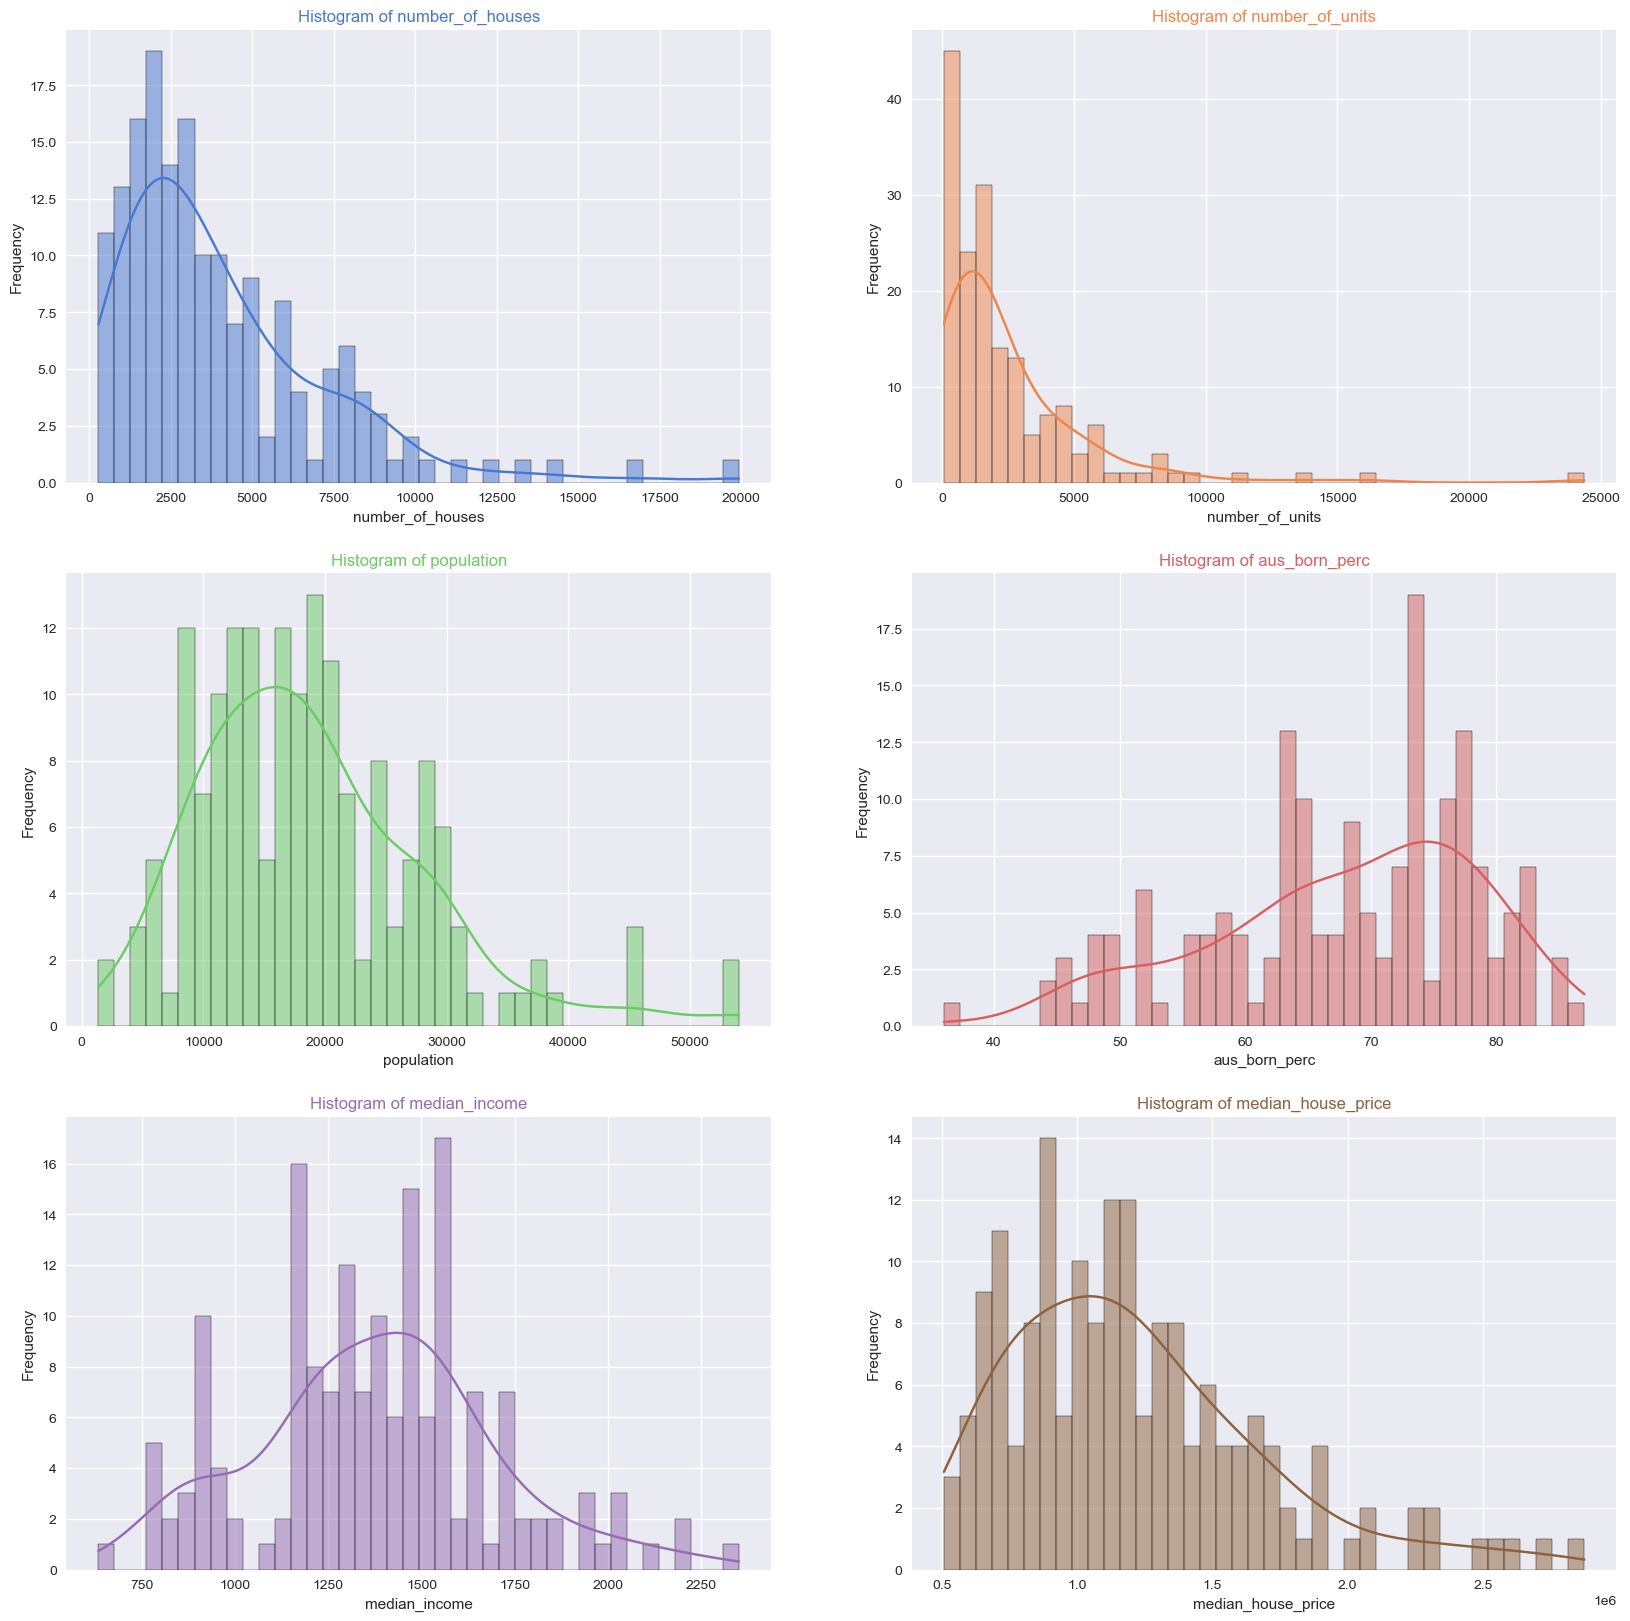

In [161]:
# Set figure size
plt.figure(figsize=(20, 20))


# Define plot colours
colors = sns.color_palette("muted", len(df_trans.columns))

for i, column in enumerate(df_trans.columns):
    plt.subplot(3, 2, i+1)

    # Plot histogram with kde and assign a different colour for each plot
    sns.histplot(data=df_trans, x=column, bins=40, kde=True, color=colors[i % len(colors)])

    # Customise plot
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}', color=colors[i % len(colors)])
    plt.grid(True)


plt.show()


Based on the facet visualisation above, we can make the following observations:

**Histogram of `number_of_houses`:**

-   This distribution is right-skewed (positively skewed), meaning there are many regions with a lower number of houses, but a few regions have a significantly larger number.
-   Most regions have between 0 to 5000 houses, with a long tail extending towards higher values.

**Histogram of `number_of_units`:**

-   This is also right-skewed, similar to the number of houses.
-   Most regions have a small number of units, with only a few areas having a large number of units (ranging from 0 to 5000 units).

**Histogram of `population`:**

-   The population distribution appears to be bimodal with two peaks.
-   There’s a slight right-skewness, with a tail indicating some regions have much larger populations.

**Histogram of `aus_born_perc`:**

-   The distribution of the percentage of Australian-born residents shows a multimodal pattern with multiple peaks.
-   There is no strong skewness, but the distribution is slightly left-skewed, with a few regions having higher percentages of Australian-born residents.

**Histogram of `median_income`:**

-   The distribution of median income appears to be roughly symmetric, although with some irregularity and minor deviations.

**Histogram of `median_house_price`:**

-   This histogram is right-skewed, with most house prices concentrated between $500,000 and $1.5 million.
-   The tail indicates that a few regions have significantly higher house prices (up to $2.5 million and beyond).

These distributions suggest that the dataset likely represents diverse areas with varying levels of development, population density and economic conditions.


## <a id='toc8_2_'></a>[Standardization](#toc0_)


Lets observe the min and max values of the columns to determine if any scaling or transformation is necessary.


In [162]:
df_trans.describe().loc[['min', 'max']]


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
min,283.0,60.0,1371.0,36.0,633.0,507200.0
max,19933.0,24380.0,54005.0,87.0,2352.0,2875800.0


Observing the minimum and maximum values of each column (feature), we note the features have different scales. This can cause issues for many machine learning algorithms. Therefore, it would be beneficial to apply scaling to these features to bring them to the same scale.

We can use standardization or min-max normalization for this purpose.


In [163]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Standardize data
df_standardized = pd.DataFrame(
    scaler.fit_transform(df_trans),
    columns=df_trans.columns)

df_standardized.describe().loc[['mean', 'std']]


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
mean,-4.229421e-17,3.172066e-17,2.114711e-17,-6.872809e-17,4.229421e-17,1.586033e-16
std,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00


In [164]:
df_standardized.head()


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
0,1.114715,0.577226,-0.135901,-0.941574,-0.421570,0.495955
1,-0.544751,-0.093703,-0.261248,-0.278128,-0.114797,0.344571
2,0.250112,0.007933,0.950760,0.669651,0.032328,0.579893
3,-0.935177,-0.658094,-1.862615,0.195762,1.174899,-0.185908
4,-0.543817,-0.600250,0.033806,-2.268465,-0.815992,-0.420172


The standardisation was performed using the `StandardScaler` class from the `sklearn.preprocessing` module.

Now, all features have a **mean of approximately 0** and a **standard deviation of approximately 1**, making them suitable for algorithms that require standardised inputs.


## <a id='toc8_3_'></a>[Normalization](#toc0_)

We can also apply min-max normalization to the features and observe the results. Min-max normalization will transform the features to fall within the range [0, 1].


In [165]:
# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Normalize data
df_normalized = pd.DataFrame(scaler.fit_transform(
    df_trans), columns=df_trans.columns)

df_normalized.describe().loc[['min', 'max']]


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


In [166]:
df_normalized.head()


,number_of_houses,number_of_units,population,aus_born_perc,median_income,median_house_price
0,0.372265,0.171998,0.305430,0.431373,0.354276,0.396437
1,0.101018,0.087582,0.283258,0.568627,0.411286,0.366208
2,0.230941,0.100370,0.497644,0.764706,0.438627,0.413198
3,0.037201,0.016571,0.000000,0.666667,0.650960,0.260280
4,0.101170,0.023849,0.335449,0.156863,0.280977,0.213502


As we can see from the output, all variables have been successfully normalized to a range of values between 0 and 1.

We can also plot the normalized variables to observe the changes visually.


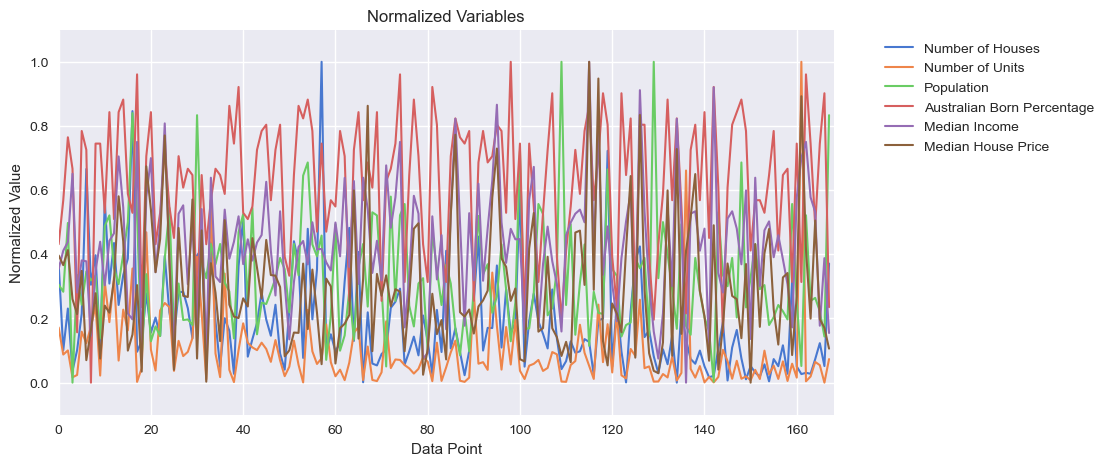

In [167]:
# Set figure size
plt.figure(figsize=(10, 5))

# Define x-axis range
x = range(len(df_normalized))

# Column names and labels
columns = ['number_of_houses', 'number_of_units', 'population', 
           'aus_born_perc', 'median_income', 'median_house_price']
labels = ['Number of Houses', 'Number of Units', 'Population', 
          'Australian Born Percentage', 'Median Income', 'Median House Price']

# Loop through columns and plot
for col, label in zip(columns, labels):
    plt.plot(x, df_normalized[col], label=label, linewidth=1.5)

# Add dynamic limits
plt.xlim(0, len(df_normalized))
plt.ylim(df_normalized.min().min() - 0.1, df_normalized.max().max() + 0.1)

# Set labels, title and legend
plt.xlabel('Data Point')
plt.ylabel('Normalized Value')
plt.title('Normalized Variables')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid and show plot
plt.grid(True)
plt.show()


## <a id='toc8_4_'></a>[Log Transformation](#toc0_)

As we observed earlier, variables like the Number of Houses, Number of Units and Median House Price showed right-skewed distributions. Log transformation would help reduce this right-skew, making the distributions more symmetric and closer to normal.

The log function compresses the scale of large values while stretching out smaller values. This would be particularly noticeable for variables with wide ranges or outliers, like Number of Units and Median House Price.

The extreme high values we saw in the normalized data (spikes to 1.0) would be brought closer to the rest of the data points. This could make patterns in the data more visible and reduce the disproportionate influence of outliers.


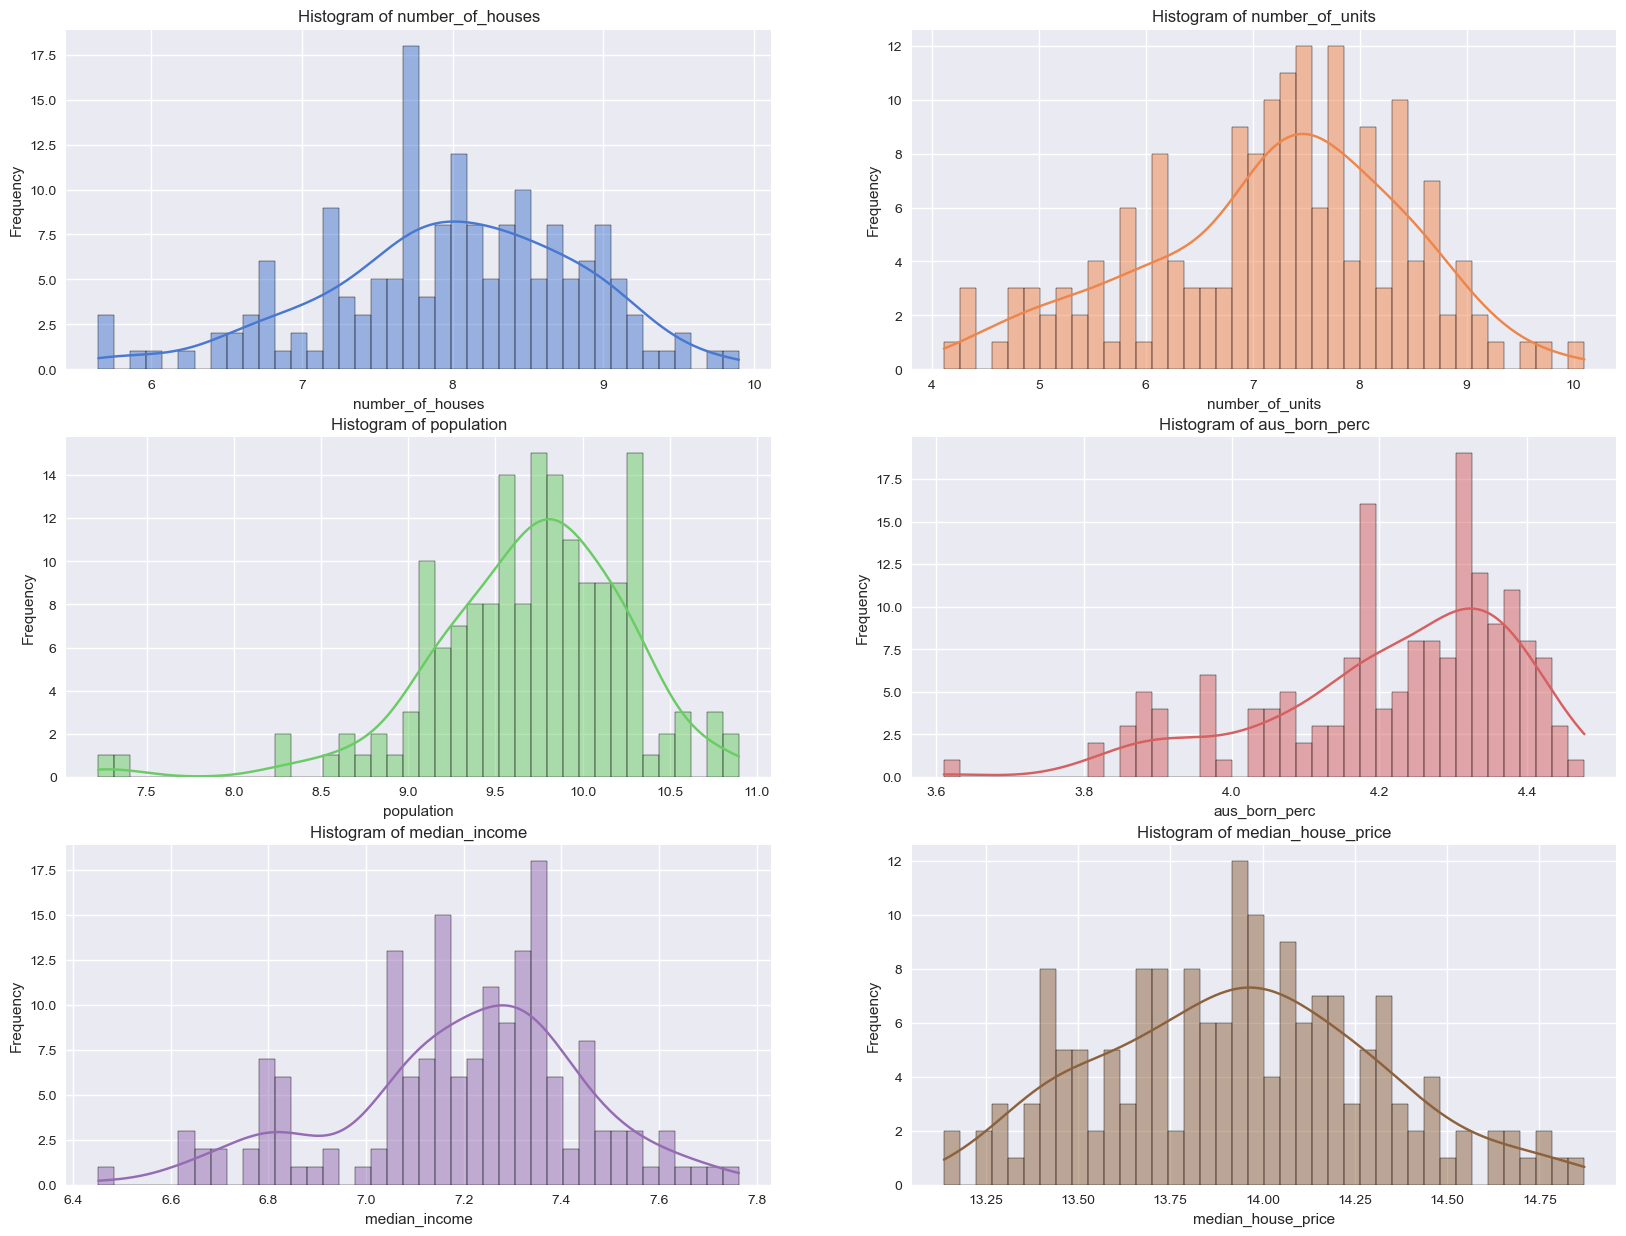

In [184]:
# Apply log transformation
df_log_transformed = df_trans.apply(np.log1p)

# Set color palette
colors = sns.color_palette("muted", len(df_trans.columns))

# Set figure size
plt.figure(figsize=(20, 15))

for i, column in enumerate(df_log_transformed.columns):
    plt.subplot(3, 2, i+1)

    # Plot histogram with kde
    sns.histplot(data=df_log_transformed, x=column, bins=40, kde=True, color=colors[i % len(colors)])

    # Customise plot
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)


plt.show()


As we can see from the visualisation above, the distributions of `number_of_houses`, `number_of_units`, `median_income` and `median_house_price` have become more normal-like after the log transformation.


## <a id='toc8_5_'></a>[Power Transformation](#toc0_)

Power transformation aims to map data from any distribution to as close to a Gaussian distribution as possible in order to stabilise variance and minimize skewness. The Yeo-Johnson transformation is a type of power transformation that supports both positive and negative data. We apply the Yeo-Johnson transformation to the features and observe the results.


In [186]:
# Instantiate PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

# Apply power transformation
df_power_transformed = pd.DataFrame(
    pt.fit_transform(df_trans),
    columns=df_trans.columns)


## <a id='toc8_6_'></a>[Box-Cox Transformation](#toc0_)

The Box-Cox transformation is a power transformation that is defined as a way to transform non-normal dependent variables into a normal shape. However, it only works with strictly positive data. Since all our data is positive, we can apply it here.


In [187]:
# Instantiate PowerTransformer
pt = PowerTransformer(method='box-cox')

# Apply power transformation
df_box_cox_transformed = pd.DataFrame(
    pt.fit_transform(df_trans),
    columns=df_trans.columns)


The Yeo-Johnson transformation and Box-Cox transformation both aim to transform the data to a more normal distribution. The Box-Cox transformation is a special case of the Yeo-Johnson transformation that only works with positive data. The Yeo-Johnson transformation is more flexible and can handle both positive and negative data. Since the result is quite similar for both transformations, we can visualise one of them to observe the changes.


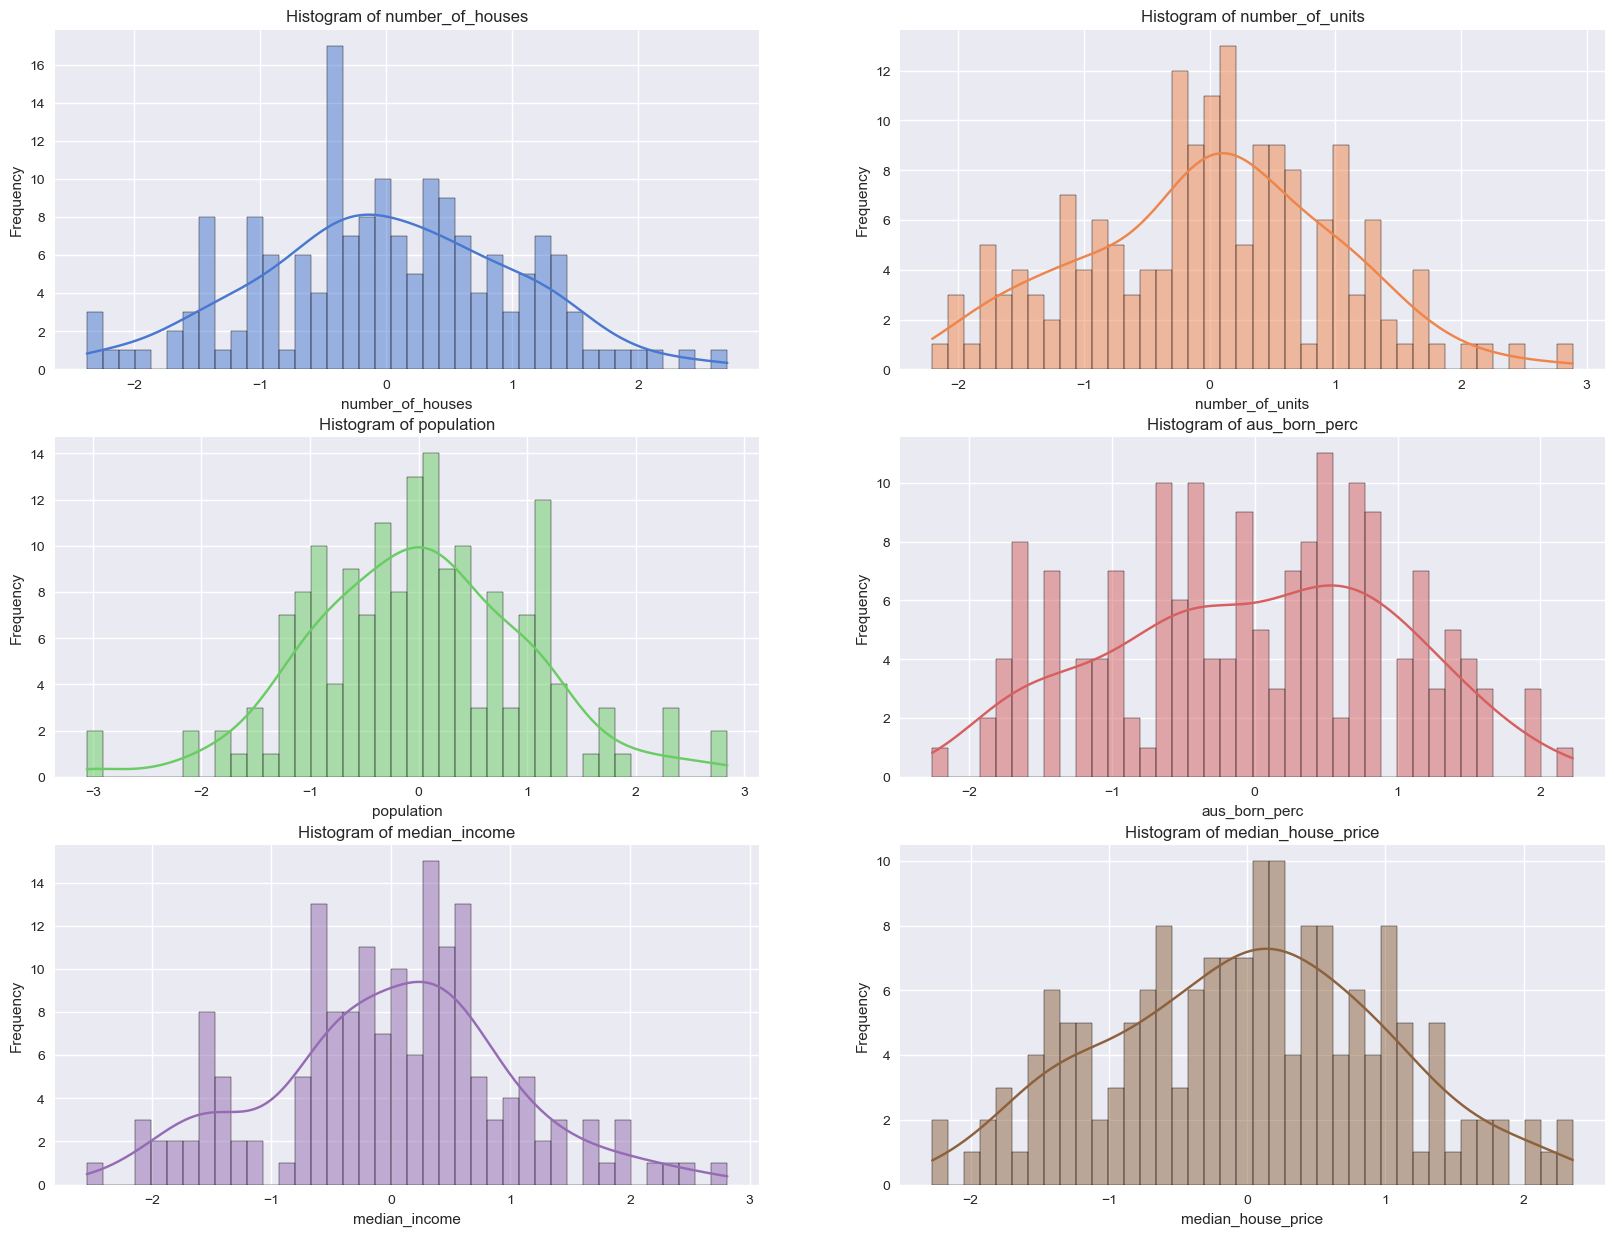

In [194]:
# Set color palette
colors = sns.color_palette("muted", len(df_trans.columns))

# Set figure size
plt.figure(figsize=(20, 15))

for i, column in enumerate(df_box_cox_transformed.columns):
    plt.subplot(3, 2, i+1)

    # Plot histogram with kde
    sns.histplot(data=df_box_cox_transformed, x=column, bins=40, kde=True, color=colors[i % len(colors)])

    # Customise plot
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)


plt.show()


As we can see from the visualisation above, the Box-Cox transformation has successfully transformed the data to a more normal distribution. This means that the transformed data is more suitable for linear regression models, which often assume that the data is normally distributed.


## <a id='toc8_7_'></a>[Effect of Data Transformation on Linear Regression Models](#toc0_)

In this section, we will study the effect of data transformation on linear regression models. For each reshaped DataFrame we can evaluate the performance using RMSE and R2 score.

The RMSE measures the average magnitude of residuals or prediction errors, while the R-squared measures the proportion of variance in the dependent variable that is predictable from our independent variables.


In [198]:
def evaluate_linear_regression(df, target_column):
    """
    Evaluates linear regression model on a given dataset and target column.
    @param df: specific DataFrame
    @param target_column: target column name (median_house_price)
    @return: Tuple of RMSE and R2 score
    """
    # Split data into X/y and train/test
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Fit model and make predictions
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return rmse, r2


# Create dictionary of DataFrames
datasets = {
    'Original': df_trans,
    'Standardized': df_standardized,
    'Normalized': df_normalized,
    'Log Transformed': df_log_transformed,
    'Yeo-Johnson Transformed': df_power_transformed,
    'Box-Cox Transformed': df_box_cox_transformed
}

# Create a list to store results
results = []

# Evaluate linear regression for each DataFrame
for name, df in datasets.items():
    rmse, r2 = evaluate_linear_regression(df, 'median_house_price')
    results.append({'Dataset': name, 'RMSE': rmse, 'R²': r2})

# Create DataFrame from results
results_df = pd.DataFrame(results)
results_df

,Dataset,RMSE,R²
0,Original,302890.979972,0.636635
1,Standardized,0.640403,0.636635
2,Normalized,0.127878,0.636635
3,Log Transformed,0.263524,0.586430
4,Yeo-Johnson Transformed,0.706581,0.588773
5,Box-Cox Transformed,0.706621,0.588726


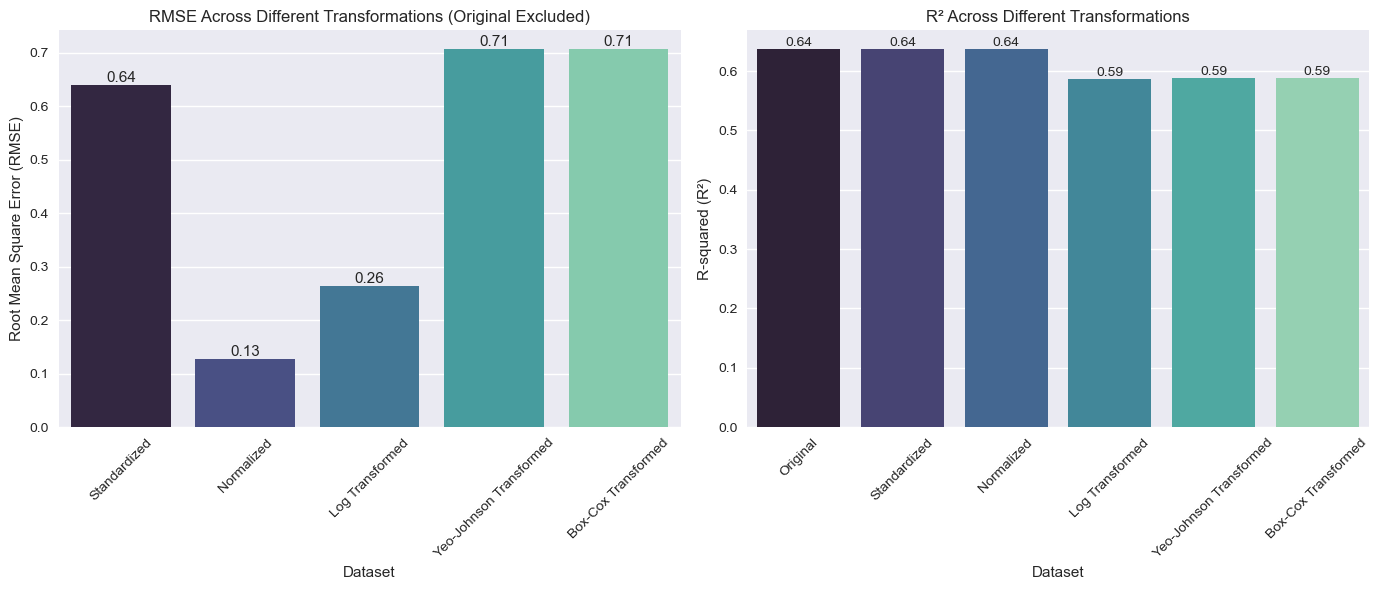

In [246]:
# Filter out the original dataset for RMSE plot
filtered_results_df = results_df[results_df['Dataset'] != 'Original']

# Set the figure size
plt.figure(figsize=(14, 6))

# Create a bar plot for RMSE
plt.subplot(1, 2, 1)
rmse_plot = sns.barplot(data=filtered_results_df, x='Dataset', y='RMSE', 
                        palette='mako', hue='Dataset', dodge=False)
plt.title('RMSE Across Different Transformations (Original Excluded)')
plt.xticks(rotation=45)
plt.ylabel('Root Mean Square Error (RMSE)')

# Add data labels on bars
for p in rmse_plot.patches:
    rmse_plot.annotate(f'{p.get_height():.2f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=11)

# Create a bar plot for R²
plt.subplot(1, 2, 2)
r2_plot = sns.barplot(data=results_df, x='Dataset', y='R²',
                      palette='mako', hue='Dataset', dodge=False)
plt.title('R² Across Different Transformations')
plt.xticks(rotation=45)
plt.ylabel('R-squared (R²)')

# Add numbers on top of bars
for p in r2_plot.patches:
    r2_plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)

# Show plots
plt.tight_layout()
plt.show()

**RMSE Across Different Transformations**

-   Standardized
    -   RMSE is 0.64, indicating a relatively high error rate compared to other transformations.
-   Normalized
    -   RMSE significantly drops to 0.13, showcasing the best prediction performance among all transformations.
    -   This suggests that normalisation provides the most reliable predictions.
-   Log Transformed
    -   RMSE stands at 0.26, which is better than standardized but not as effective as normalisation.
-   Yeo-Johnson and Box-Cox Transformed:
    -   Both transformations result in an RMSE of approximately 0.71, indicating the poorest performance in prediction accuracy among the methods considered.

**R-squared Across Different Transformations**

-   Original and Standardized
    -   Both have an R² value of 0.64, meaning they explain the same proportion of variance in the target variable.
-   Normalized
    -   Also maintains an R² of 0.64, suggesting it retains the same explanatory power despite the improvement in RMSE.
-   Log Transformed, Yeo-Johnson, and Box-Cox Transformed
    -   Each of these transformations results in an R² of 0.59, indicating a reduced explanatory power compared to the other transformations.

**Overall Observations**

-   This Normalized data resulted in the best prediction performance, as indicated by the significantly lower RMSE (0.13) while maintaining an R² of 0.64. This suggests that the model using the normalized dataset not only makes more accurate predictions but also retains the capacity to explain the variance in the target variable effectively.
-   The Standardized had a high RMSE (0.64) compared to normalization and it did not enhance the model's explanatory power beyond what was achieved with the original dataset.
-   The Log Transformed, Yeo-Johnson, and Box-Cox Transformed datasets resulted in higher RMSE values (0.26 for log, and around 0.71 for Yeo-Johnson and Box-Cox), indicating poorer predictive performance. The R² values also reflect a decline in explanatory power.


# <a id='toc9_'></a>[Summary](#toc0_)

This project aimed to integrate diverse datasets related to housing in Victoria, Australia, into a unified format for predictive analysis. The objective was to assess how different data transformation techniques affect the performance of linear regression models for housing price prediction.

Data from various sources, including CSV, XML, JSON, shapefiles, PDFs and web scraping, were integrated to include property details, geographic boundaries, public transport information and additional housing statistics. Key steps included mapping properties to suburbs using spatial joins, calculating distances to the nearest train stations and extracting housing-related data from web sources.

After data integration, we applied several transformation techniques, including z-score standardisation, rescaling, logarithmic scaling and Yeo-Johnson transformations. These transformations were tested on linear regression models to evaluate their impact on predictive performance. Normalisation provided the best results, improving model accuracy with the lowest RMSE and highest R² values.

This project highlights the importance of data preprocessing in enhancing model performance and suggests that future work could explore additional feature engineering techniques to further improve prediction accuracy.


# <a id='toc10_'></a>[References](#toc0_)

[1] https://geopandas.org/en/stable/docs.html  
[2] https://developers.google.com/transit/gtfs/reference  
[3] https://developers.google.com/transit/gtfs/reference#stop_timestxt  
[4] https://stackoverflow.com/questions/4913349/  
[5] https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings  
[6] https://python-visualization.github.io/folium/quickstart.html#Markers  
[7] https://en.wikipedia.org/wiki/Power_transform
